In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv
from fyers_apiv3 import fyersModel

# Set up plotting style - using a modern style that works with all versions
plt.style.use('default')  # Use the default style instead of seaborn-darkgrid
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['axes.grid'] = True  # Enable grid manually

In [2]:
# Load variables from .env file (if it exists)
try:
    load_dotenv()
    print("Environment variables loaded from .env file")
except:
    print("No .env file found or error loading it - using hardcoded values")

# Get credentials - first try environment variables, then use hardcoded values
FYERS_CLIENT_ID = os.getenv('FYERS_CLIENT_ID', 'GBJMHA44CH-100')
FYERS_SECRET_KEY = os.getenv('FYERS_SECRET_KEY', 'YW543H05CG')
REDIRECT_URI = "https://www.google.com/"

# Print masked credentials for verification
print(f"Using Client ID: {FYERS_CLIENT_ID[:5]}...{FYERS_CLIENT_ID[-3:]}")

Environment variables loaded from .env file
Using Client ID: GBJMH...100


In [3]:
def init_fyers_session():
    """Initialize a Fyers session and return the session object"""
    print("Initializing Fyers session...")
    try:
        session = fyersModel.SessionModel(
            client_id=FYERS_CLIENT_ID,
            secret_key=FYERS_SECRET_KEY,
            redirect_uri=REDIRECT_URI,
            response_type='code',
            grant_type='authorization_code'
        )
        print("Session initialized successfully")
        return session
    except Exception as e:
        print(f"Error initializing session: {str(e)}")
        return None

# Initialize session
session = init_fyers_session()

Initializing Fyers session...
Session initialized successfully


In [4]:
# Generate the authorization URL
try:
    auth_url = session.generate_authcode()
    print("Please visit this URL in your browser to authorize the application:")
    print("\n" + auth_url + "\n")
    print("After authorization, you'll be redirected to Google.")
    print("Copy the complete URL from your browser's address bar and paste it in the next cell.")
except Exception as e:
    print(f"Error generating auth URL: {str(e)}")

Please visit this URL in your browser to authorize the application:

https://api-t1.fyers.in/api/v3/generate-authcode?client_id=GBJMHA44CH-100&redirect_uri=https%3A%2F%2Fwww.google.com%2F&response_type=code&state=None

After authorization, you'll be redirected to Google.
Copy the complete URL from your browser's address bar and paste it in the next cell.


In [5]:
# Input the redirected URL
redirect_url = input("Paste the redirect URL here: ")

try:
    # Extract the auth code from the URL
    if "auth_code=" in redirect_url:
        auth_code = redirect_url.split("auth_code=")[1].split("&")[0]
        print(f"Extracted auth code: {auth_code[:10]}...")
        
        # Set the auth code and generate token
        session.set_token(auth_code)
        response = session.generate_token()
        
        # Extract and save the access token
        if "access_token" in response:
            access_token = response["access_token"]
            print(f"Access token generated successfully: {access_token[:10]}...")
            
            # Save token to file for future use
            with open("fyers_token.txt", "w") as f:
                f.write(access_token)
            print("Token saved to fyers_token.txt for future use")
        else:
            print(f"Failed to generate token: {response}")
    else:
        print("Could not extract auth code from the URL. Make sure you copied the complete URL.")
except Exception as e:
    print(f"Error processing auth code: {str(e)}")

Extracted auth code: eyJ0eXAiOi...
Access token generated successfully: eyJ0eXAiOi...
Token saved to fyers_token.txt for future use


In [6]:
def create_fyers_model(token):
    """Create a Fyers model with the provided access token"""
    print("Creating Fyers model...")
    try:
        fyers = fyersModel.FyersModel(
            client_id=FYERS_CLIENT_ID,
            token=token,
            is_async=False, 
            log_path=os.getcwd()
        )
        return fyers
    except Exception as e:
        print(f"Error creating Fyers model: {str(e)}")
        return None

# Create the Fyers model
try:
    fyers = create_fyers_model(access_token)
    print("Fyers model created")
except NameError:
    print("No access token available. If you saved the token previously, try loading it from file.")
    try:
        with open("fyers_token.txt", "r") as f:
            saved_token = f.read().strip()
        print(f"Loaded token from file: {saved_token[:10]}...")
        fyers = create_fyers_model(saved_token)
    except:
        print("Could not load token from file either.")

Creating Fyers model...
Fyers model created


In [8]:
# Test the connection by fetching profile information
try:
    profile = fyers.get_profile()

    if profile and 's' in profile and profile['s'] == 'ok':
        print("✅ Successfully connected to Fyers API!")
        print(f"Name: {profile['data'].get('name', 'N/A')}")
        print(f"Email: {profile['data'].get('email', 'N/A')}")
        print(f"Client ID: {profile['data'].get('fy_id', 'N/A')}")
    else:
        print(f"❌ Failed to connect: {profile}")
except Exception as e:
    print(f"Error testing connection: {str(e)}")

✅ Successfully connected to Fyers API!
Name: PAWAN RATHORE
Email: N/A
Client ID: YP03333


In [37]:
def fetch_crude_data(symbol="MCX:CRUDEOIL25MARFUT", resolution=1, days=90):
    """
    Fetch historical crude oil data from Fyers
    
    Parameters:
    symbol (str): Trading symbol for crude oil
    resolution (int/str): Timeframe (1, 5, 15, 30, 60, D, W, M)
    days (int): Number of days of historical data to fetch
    
    Returns:
    pandas.DataFrame: Dataframe with OHLCV data
    """
    try:
        # Calculate date range
        end_date = datetime.now().strftime("%Y-%m-%d")
        start_date = (datetime.now() - timedelta(days=days)).strftime("%Y-%m-%d")
        last_updated_time = datetime.now()
        
        print(f"Fetching data for {symbol} from {start_date} to {end_date}...")
        
        # Prepare request parameters
        data = {
            "symbol": symbol,
            "resolution": resolution,
            "date_format": "1",
            "range_from": start_date,
            "range_to": end_date,
            "cont_flag": "1"
        }

        # Make API request
        response = fyers.history(data)
        
        if response and 's' in response and response['s'] == 'ok':
            # Create DataFrame from response
            df = pd.DataFrame(
                response['candles'], 
                columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']
            )
            
            # Convert timestamp to datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
            df['timestamp'] = df['timestamp'].dt.tz_convert('Asia/Kolkata')
            df['timestamp'] = df['timestamp'].dt.tz_localize(None)
            
            # Add metadata
            df["last_updated_time"] = last_updated_time
            
            print(f"✅ Successfully fetched {len(df)} data points")
            return df
        else:
            print(f"❌ Failed to fetch data: {response}")
            return None
    except Exception as e:
        print(f"❌ Error fetching data: {str(e)}")
        return None

In [38]:
# Define the symbol for crude oil futures
# Note: The symbol might change based on the expiry month, update as needed
crude_symbol = "MCX:CRUDEOIL25MARFUT"  # March 2025 contract

# Try fetching minute data first (recent 5 days)
# If this works, we can proceed with other timeframes
try:
    print("Fetching 1-minute data (last 5 days)...")
    minute_data = fetch_crude_data(symbol=crude_symbol, resolution=1, days=5)
    
    if minute_data is not None and not minute_data.empty:
        print("Now fetching hourly data (last 30 days)...")
        hourly_data = fetch_crude_data(symbol=crude_symbol, resolution=60, days=30)
        
        print("Now fetching daily data (last 365 days)...")
        daily_data = fetch_crude_data(symbol=crude_symbol, resolution="D", days=365)
    else:
        print("Skipping other timeframes since minute data fetch failed")
except Exception as e:
    print(f"Error during data fetching: {str(e)}")

Fetching 1-minute data (last 5 days)...
Fetching data for MCX:CRUDEOIL25MARFUT from 2025-02-22 to 2025-02-27...
✅ Successfully fetched 3059 data points
Now fetching hourly data (last 30 days)...
Fetching data for MCX:CRUDEOIL25MARFUT from 2025-01-28 to 2025-02-27...
✅ Successfully fetched 345 data points
Now fetching daily data (last 365 days)...
Fetching data for MCX:CRUDEOIL25MARFUT from 2024-02-28 to 2025-02-27...
✅ Successfully fetched 259 data points


In [39]:
# Let's examine the minute data first
try:
    if 'minute_data' in locals() and minute_data is not None and not minute_data.empty:
        print("\nMinute Data Sample:")
        display(minute_data.head())
        print(f"Data shape: {minute_data.shape}")
        print(f"Date range: {minute_data['timestamp'].min()} to {minute_data['timestamp'].max()}")
        
        # Basic statistics
        print("\nBasic Statistics:")
        display(minute_data[['open', 'high', 'low', 'close', 'volume']].describe())
    else:
        print("No minute data available to examine")
except Exception as e:
    print(f"Error examining data: {str(e)}")


Minute Data Sample:


,timestamp,open,high,low,close,volume,last_updated_time
0,2025-02-24 09:00:00,6109,6113,6108,6110,34,2025-02-27 23:13:17.032995
1,2025-02-24 09:01:00,6110,6112,6110,6112,21,2025-02-27 23:13:17.032995
2,2025-02-24 09:02:00,6112,6115,6112,6115,19,2025-02-27 23:13:17.032995
3,2025-02-24 09:03:00,6115,6115,6113,6114,29,2025-02-27 23:13:17.032995
4,2025-02-24 09:04:00,6114,6116,6114,6116,5,2025-02-27 23:13:17.032995


Data shape: (3059, 7)
Date range: 2025-02-24 09:00:00 to 2025-02-27 23:13:00

Basic Statistics:


,open,high,low,close,volume
count,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000
mean,6095.884930,6097.050997,6094.801569,6095.911082,15.702190
std,63.603439,63.488534,63.688660,63.612499,35.623612
min,5980.000000,5981.000000,5976.000000,5980.000000,0.000000
25%,6025.500000,6028.000000,6024.000000,6026.000000,2.000000
50%,6109.000000,6109.000000,6108.000000,6109.000000,6.000000
75%,6141.000000,6142.000000,6139.000000,6141.000000,16.000000
max,6203.000000,6206.000000,6202.000000,6204.000000,952.000000


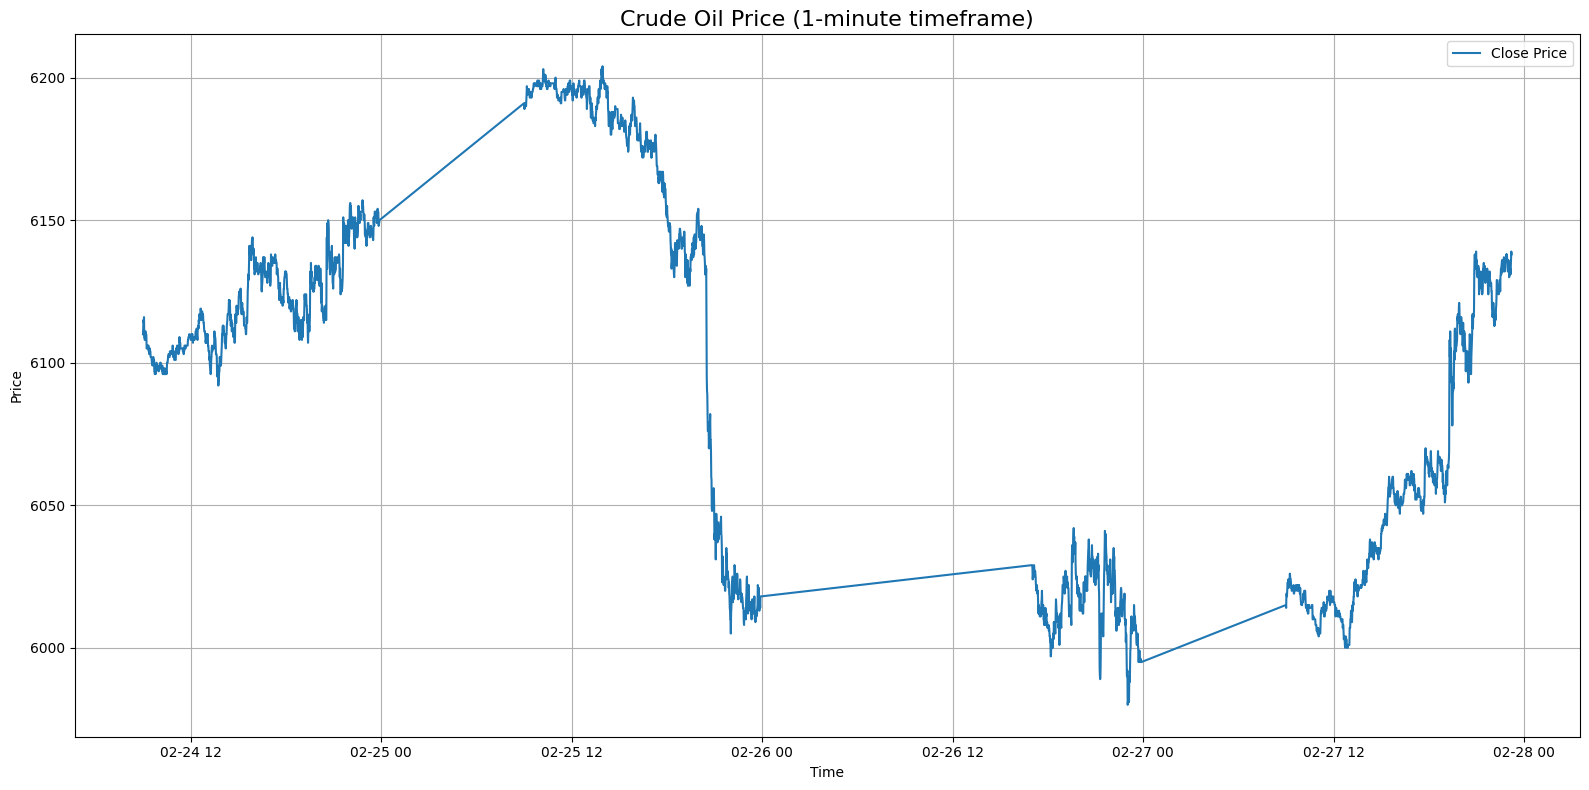

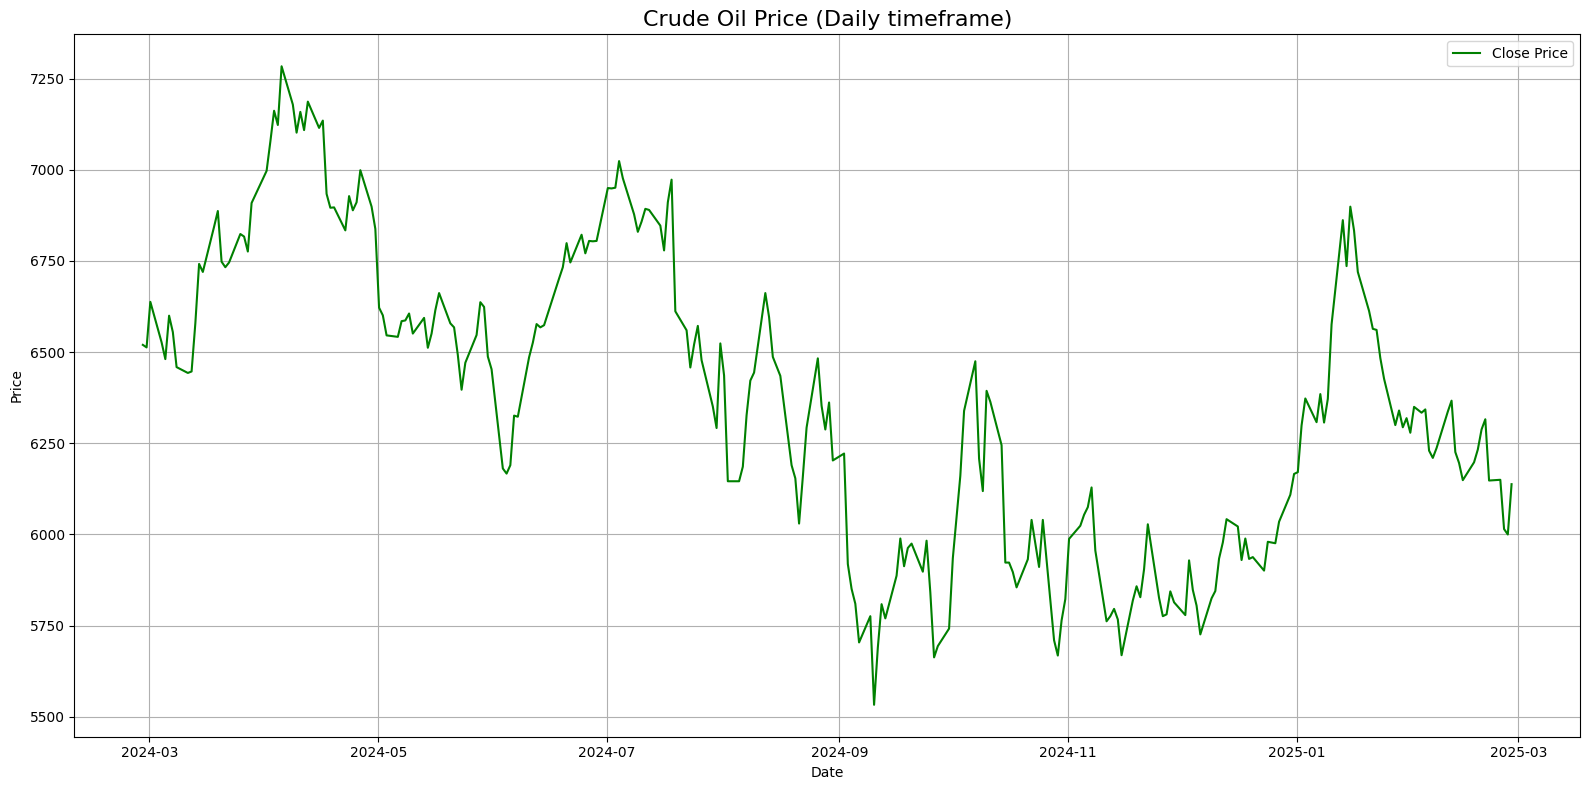

In [40]:
# Create a simple price chart with the minute data
try:
    if 'minute_data' in locals() and minute_data is not None and not minute_data.empty:
        # Set timestamp as index for easier plotting
        data_to_plot = minute_data.set_index('timestamp')
        
        # Plot the data
        plt.figure(figsize=(16, 8))
        plt.plot(data_to_plot.index, data_to_plot['close'], label='Close Price')
        plt.title('Crude Oil Price (1-minute timeframe)', fontsize=16)
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # If you want to see the daily data as well
        if 'daily_data' in locals() and daily_data is not None and not daily_data.empty:
            daily_to_plot = daily_data.set_index('timestamp')
            plt.figure(figsize=(16, 8))
            plt.plot(daily_to_plot.index, daily_to_plot['close'], label='Close Price', color='green')
            plt.title('Crude Oil Price (Daily timeframe)', fontsize=16)
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
    else:
        print("No data available to plot")
except Exception as e:
    print(f"Error plotting data: {str(e)}")

In [41]:
# Function to safely save data to CSV
def save_data_to_csv(df, filename):
    """Save DataFrame to CSV with error handling"""
    try:
        if df is not None and not df.empty:
            df.to_csv(filename, index=False)
            print(f"✅ Data saved to {filename}")
            return True
        else:
            print(f"⚠️ No data to save to {filename}")
            return False
    except Exception as e:
        print(f"❌ Error saving to {filename}: {str(e)}")
        return False

# Save the data to CSV files
try:
    if 'minute_data' in locals():
        save_data_to_csv(minute_data, "crude_oil_minute_data.csv")
    
    if 'hourly_data' in locals():
        save_data_to_csv(hourly_data, "crude_oil_hourly_data.csv")
    
    if 'daily_data' in locals():
        save_data_to_csv(daily_data, "crude_oil_daily_data.csv")
except Exception as e:
    print(f"Error in save process: {str(e)}")

✅ Data saved to crude_oil_minute_data.csv
✅ Data saved to crude_oil_hourly_data.csv
✅ Data saved to crude_oil_daily_data.csv


In [42]:
def fetch_live_quote(symbol="MCX:CRUDEOIL25MARFUT"):
    """Fetch current live market quote for a symbol"""
    try:
        print(f"Fetching live quote for {symbol}...")
        response = fyers.quotes({"symbols": symbol})
        
        if 'd' in response and response['s'] == 'ok':
            print("✅ Successfully fetched live quote")
            return response['d']
        else:
            print(f"❌ Failed to fetch quote: {response}")
            return None
    except Exception as e:
        print(f"❌ Error fetching live quote: {str(e)}")
        return None

# Get the latest quote
live_quote = fetch_live_quote(crude_symbol)

# Display the quote in a readable format
if live_quote:
    for quote in live_quote:
        quote_data = quote.get('v', {})
        
        print("\nLive Quote Details:")
        print(f"Symbol: {quote_data.get('symbol', 'N/A')}")
        print(f"Last Price: {quote_data.get('lp', 'N/A')}")
        print(f"Change: {quote_data.get('ch', 'N/A')} ({quote_data.get('chp', 'N/A')}%)")
        print(f"Open: {quote_data.get('open_price', 'N/A')}")
        print(f"High: {quote_data.get('high_price', 'N/A')}")
        print(f"Low: {quote_data.get('low_price', 'N/A')}")
        print(f"Volume: {quote_data.get('volume', 'N/A')}")
        print(f"Bid: {quote_data.get('bid', 'N/A')} x {quote_data.get('bids', 'N/A')}")
        print(f"Ask: {quote_data.get('ask', 'N/A')} x {quote_data.get('asks', 'N/A')}")

Fetching live quote for MCX:CRUDEOIL25MARFUT...
✅ Successfully fetched live quote

Live Quote Details:
Symbol: MCX:CRUDEOIL25MARFUT
Last Price: 6138
Change: 138 (2.3%)
Open: 6020
High: 6141
Low: 5999
Volume: 14104
Bid: 6138 x N/A
Ask: 6139 x N/A


In [43]:
def prepare_data_for_analyzer(df):
    """
    Prepare the Fyers data for use with the market analyzer
    
    Parameters:
    df (pandas.DataFrame): Dataframe from Fyers API
    
    Returns:
    pandas.DataFrame: Formatted dataframe ready for analysis
    """
    try:
        if df is None or df.empty:
            print("No data to prepare for analyzer")
            return None
        
        # Make a copy to avoid modifying the original
        analysis_df = df.copy()
        
        # Calculate additional metrics that might be useful for your analyzer
        # 1. Calculate returns
        analysis_df['returns'] = analysis_df['close'].pct_change()
        
        # 2. Calculate typical price
        analysis_df['typical_price'] = (analysis_df['high'] + analysis_df['low'] + analysis_df['close']) / 3
        
        # 3. Calculate range
        analysis_df['range'] = analysis_df['high'] - analysis_df['low']
        
        # 4. Add a date column for easier filtering
        analysis_df['date'] = analysis_df['timestamp'].dt.date
        
        # 5. Add time components
        analysis_df['hour'] = analysis_df['timestamp'].dt.hour
        analysis_df['minute'] = analysis_df['timestamp'].dt.minute
        
        print("Data prepared for analyzer successfully")
        return analysis_df
    except Exception as e:
        print(f"Error preparing data for analyzer: {str(e)}")
        return None

# Prepare the data for your market analyzer
analyzer_ready_data = None
if 'minute_data' in locals() and minute_data is not None and not minute_data.empty:
    analyzer_ready_data = prepare_data_for_analyzer(minute_data)
    
    # Save the analyzer-ready data to a separate CSV
    if analyzer_ready_data is not None:
        analyzer_ready_data.to_csv("analyzer_ready_data.csv", index=False)
        print("✅ Analyzer-ready data saved to analyzer_ready_data.csv")

Data prepared for analyzer successfully
✅ Analyzer-ready data saved to analyzer_ready_data.csv
